# MLFlow Demo - Forecasting hourly electricity consumption of Italy

[From Kaggle - "Forecasting electricity consumption of Germany" Notebook](https://www.kaggle.com/francoisraucent/forecasting-electricity-consumption-of-germany)

Electricity grid and market have become increasingly challenging to operate and maintain in the recent years. In particular, one of the main responsibilities of transmission system operators and aggregators consists in maintaining balance between production and consumption. With the development and spread of renewable energy sources, production has become more intermittent which requires even more effort to maintain the balance.

One of the underlying task of maintaining grid balance, it to forecast the consumption. In this analysis, we train and test a few models to forecast total german load, on an hourly basis, with a lead time of 24 hours.

The data was retrieved from [ENTSO-E Transparency Platform](https://transparency.entsoe.eu/), which provides access to electricity generation, transportation, and consumption data for the pan-European market.

This notebook follows a structure similar to [this nice tutorial](https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost) from [Rob Mulla](https://www.kaggle.com/robikscube). The main adaptations are the following :
* it applies to German load instead of PJM data covering US east region,
* it includes additional features such as holidays and lag features,
* a linear model, and a random forest are used as baselines in addition to the XGB model,
* the final XGB model is finetuned with some grid search CV.

In [20]:
import pandas as pd
import numpy as np
import math

import holidays
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import sys

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, FunctionTransformer
)
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import (
    train_test_split, KFold, GridSearchCV, ParameterGrid,
)
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, DMatrix, plot_importance
from xgboost import cv as xgb_cv

/home/enrico/anaconda3/envs/mlflow/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Import MLFlow

In [21]:
import mlflow

## Loading the data

We will work with consumption data ranging from Jan 2015 to Jan 2020.

In [22]:
STUDY_START_DATE = pd.Timestamp("2015-01-01 00:00", tz="utc")
STUDY_END_DATE = pd.Timestamp("2020-01-31 23:00", tz="utc")

The German load data is originally available with 15-min resolution. We have resampled it on an hourly basis for this analysis.

In [23]:
it_load = pd.read_csv("datasets/it.csv")
it_load = it_load.drop(columns="end").set_index("start")
it_load.index = pd.to_datetime(it_load.index)
it_load.index.name = "time"
it_load = it_load.groupby(pd.Grouper(freq="h")).mean()
it_load = it_load.loc[
    (it_load.index >= STUDY_START_DATE) & (it_load.index <= STUDY_END_DATE), :
]
it_load.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44568 entries, 2015-01-01 00:00:00+00:00 to 2020-01-31 23:00:00+00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   load    44568 non-null  float64
dtypes: float64(1)
memory usage: 696.4 KB


Let's define our test set as the last 12 months of data

In [24]:
def split_train_test(df, split_time):
    df_train = df.loc[df.index < split_time]
    df_test = df.loc[df.index >= split_time]
    return df_train, df_test

df_train, df_test = split_train_test(
    it_load, pd.Timestamp("2019-02-01", tz="utc")
)

Our training data covers roughly 20% of the data set

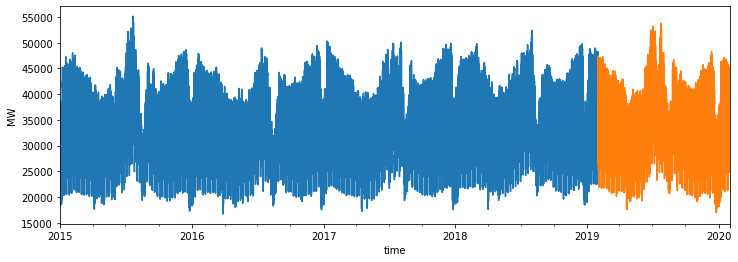

In [25]:
ax = df_train["load"].plot(figsize=(12, 4), color="tab:blue")
_ = df_test["load"].plot(ax=ax, color="tab:orange", ylabel="MW")

## Data preparation

There are no missing observations in our training data (there actually were a few missing observations on 15-min granularity, but we took care of these with hourly aggregation when loading the data).

In [26]:
df_train.loc[df_train["load"].isna(), :].index

/home/enrico/anaconda3/envs/mlflow/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


DatetimeIndex([], dtype='datetime64[ns, UTC]', name='time', freq='H')

### Create features for training

The following features are used for training our forecast models :
* time features: month, weekday and hour
* national holiday features, as a boolean time series
* lag features: load data with a lag values ranging from 24 to 48 hours

In [27]:
def add_time_features(df):
    cet_index = df.index.tz_convert("CET")
    df["month"] = cet_index.month
    df["weekday"] = cet_index.weekday
    df["hour"] = cet_index.hour
    return df

def add_holiday_features(df):
    it_holidays = holidays.Italy()
    cet_dates = pd.Series(df.index.tz_convert("CET"), index=df.index)
    df["holiday"] = cet_dates.apply(lambda d: d in it_holidays)
    df["holiday"] = df["holiday"].astype(int)
    return df

def add_lag_features(df, col="load"):
    for n_hours in range(24, 49):
        shifted_col = df[col].shift(n_hours, "h")
        shifted_col = shifted_col.loc[df.index.min(): df.index.max()]
        label = f"{col}_lag_{n_hours}"
        df[label] = np.nan
        df.loc[shifted_col.index, label] = shifted_col
    return df

def add_all_features(df, target_col="load"):
    df = df.copy()
    df = add_time_features(df)
    df = add_holiday_features(df)
    df = add_lag_features(df, col=target_col)
    return df


The lag features introduce a few missing values which we will move out of the analysis. The features of our training set are then the following :

In [28]:
df_train = add_all_features(df_train).dropna()
df_test = add_all_features(df_test).dropna()
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35760 entries, 2015-01-03 00:00:00+00:00 to 2019-01-31 23:00:00+00:00
Freq: H
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   load         35760 non-null  float64
 1   month        35760 non-null  int64  
 2   weekday      35760 non-null  int64  
 3   hour         35760 non-null  int64  
 4   holiday      35760 non-null  int64  
 5   load_lag_24  35760 non-null  float64
 6   load_lag_25  35760 non-null  float64
 7   load_lag_26  35760 non-null  float64
 8   load_lag_27  35760 non-null  float64
 9   load_lag_28  35760 non-null  float64
 10  load_lag_29  35760 non-null  float64
 11  load_lag_30  35760 non-null  float64
 12  load_lag_31  35760 non-null  float64
 13  load_lag_32  35760 non-null  float64
 14  load_lag_33  35760 non-null  float64
 15  load_lag_34  35760 non-null  float64
 16  load_lag_35  35760 non-null  float64
 17  load_lag_36  35760 non-null  floa

We then separate target values from features into distinct data frames.

In [29]:
target_col = "load"
X_train = df_train.drop(columns=target_col)
y_train = df_train.loc[:, target_col]
X_test = df_test.drop(columns=target_col)
y_test = df_test.loc[:, target_col]

/home/enrico/anaconda3/envs/mlflow/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Data preparation pipeline

We'll use the following data preparation pipeline to apply one-hot encoders on categorical feratures (time features), and a standard scaler on numerical features (lag features).

In [30]:
def fit_prep_pipeline(df):
    cat_features = ["month", "weekday", "hour"]  # categorical features
    bool_features = ["holiday"]  # boolean features
    num_features = [c for c in df.columns
                    if c.startswith("load_lag")]  # numerical features
    prep_pipeline = ColumnTransformer([
        ("cat", OneHotEncoder(), cat_features),
        ("bool", FunctionTransformer(), bool_features),  # identity
        ("num", StandardScaler(), num_features),
    ])
    prep_pipeline = prep_pipeline.fit(df)
    
    feature_names = []
    one_hot_tf = prep_pipeline.transformers_[0][1]
    for i, cat_feature in enumerate(cat_features):
        categories = one_hot_tf.categories_[i]
        cat_names = [f"{cat_feature}_{c}" for c in categories]
        feature_names += cat_names
    feature_names += (bool_features + num_features)
    
    return feature_names, prep_pipeline

We then fit pipeline on training data, and apply it on training and test sets

In [31]:
feature_names, prep_pipeline = fit_prep_pipeline(X_train)

X_train_prep = prep_pipeline.transform(X_train)
X_train_prep = pd.DataFrame(X_train_prep, columns=feature_names, index=df_train.index)
X_test_prep = prep_pipeline.transform(X_test)
X_test_prep = pd.DataFrame(X_test_prep, columns=feature_names, index=df_test.index)

X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35760 entries, 2015-01-03 00:00:00+00:00 to 2019-01-31 23:00:00+00:00
Freq: H
Data columns (total 69 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   month_1      35760 non-null  float64
 1   month_2      35760 non-null  float64
 2   month_3      35760 non-null  float64
 3   month_4      35760 non-null  float64
 4   month_5      35760 non-null  float64
 5   month_6      35760 non-null  float64
 6   month_7      35760 non-null  float64
 7   month_8      35760 non-null  float64
 8   month_9      35760 non-null  float64
 9   month_10     35760 non-null  float64
 10  month_11     35760 non-null  float64
 11  month_12     35760 non-null  float64
 12  weekday_0    35760 non-null  float64
 13  weekday_1    35760 non-null  float64
 14  weekday_2    35760 non-null  float64
 15  weekday_3    35760 non-null  float64
 16  weekday_4    35760 non-null  float64
 17  weekday_5    35760 non-null  floa

## Training regression models

Three models will be trained for our prediction task : a simple linear models with L1 and L2 regularisation, a random forest, and gradient boosting model (based on XGBoost library).

In [32]:
with mlflow.start_run():
    mlflow.set_experiment('/mlflow_test/electricity-consumption-of-italy')

/home/enrico/anaconda3/envs/mlflow/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
tol_parameter = int(sys.argv[1])
random_state_parameter = int(sys.argv[2])

In [79]:
lin_model = SGDRegressor(penalty="elasticnet", tol=tol_parameter, random_state=random_state_parameter)
rf_model = RandomForestRegressor(
    n_estimators=100, criterion='mse', min_samples_leaf=0.001, random_state=42
)
xgb_model = XGBRegressor(n_estimators=1000)

In [ ]:
mlflow.log_param("tol - SGDRegressor", tol_parameter)
mlflow.log_param("random_state - SGDRegressor ", random_state_parameter)


### Learning curves

The behaviour and performance of the previous models can be represented with learning curves. These are showing the models performance evolution based on experience (the amount of training data that is fed to the algorithm).

In [ ]:
def plot_learning_curves(steps, train_errors, val_errors, ax=None, title=""):
    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(6, 4))
    train_rmse = np.sqrt(train_errors)
    val_rmse = np.sqrt(val_errors)
    ax.plot(steps, train_rmse, color="tab:blue",
            marker=".", label="training")
    ax.plot(steps, val_rmse, color="tab:orange",
            marker=".", label="validation")
    ylim = (0.8*np.median(train_rmse),
            1.5*np.median(val_rmse))
    ax.set_ylim(ylim)
    ax.set_xlabel("Number of observations")
    ax.set_ylabel("RMSE (MW)")
    ax.set_title(title)
    ax.legend()
    ax.grid()

In [80]:
def compute_learning_curves(model, model_name, X, y, curve_step, verbose=False):
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )
    n_train_obs = X_train.shape[0]
    n_iter = math.ceil(n_train_obs / curve_step)
    train_errors, val_errors, steps = [], [], []
    for i in range(n_iter):
        n_obs = (i+1) * curve_step
        n_obs = min(n_obs, n_train_obs)
        model.fit(X_train[:n_obs], y_train[:n_obs])
        
        
        y_train_predict = model.predict(X_train[:n_obs])
        y_val_predict = model.predict(X_val)
        
        train_mse = mean_squared_error(y_train[:n_obs], y_train_predict)
        val_mse = mean_squared_error(y_val, y_val_predict)
        
        mlflow.log_metric("train_mse", train_mse)
        mlflow.log_metric("val_mse", val_mse)
                
        train_errors.append(train_mse)
        val_errors.append(val_mse)
        steps.append(n_obs)
        if verbose:
            msg = "Iteration {0}/{1}: train_rmse={2:.2f}, val_rmse={3:.2f}".format(
                i+1, n_iter, np.sqrt(train_mse), np.sqrt(val_mse)
            )
            print(msg)
    return model, steps, train_errors, val_errors

The linear model achieves a validation RMSE of ±3230MW. The training RMSE is ±3100MW which is relatively close.

In [81]:
sgd_regressor_model, steps, train_mse, val_mse = compute_learning_curves(
    lin_model, "SGDRegressor", X_train_prep, y_train, 500, verbose=True
)

Iteration 1/58: train_rmse=3043.03, val_rmse=14937.41
Iteration 2/58: train_rmse=2909.15, val_rmse=9690.62
Iteration 3/58: train_rmse=2710.22, val_rmse=7528.65
Iteration 4/58: train_rmse=2617.95, val_rmse=7553.13
Iteration 5/58: train_rmse=2520.96, val_rmse=6444.83
Iteration 6/58: train_rmse=2586.17, val_rmse=5781.40
Iteration 7/58: train_rmse=2531.64, val_rmse=5669.54
Iteration 8/58: train_rmse=2653.56, val_rmse=4877.41
Iteration 9/58: train_rmse=2648.47, val_rmse=3804.90
Iteration 10/58: train_rmse=2628.64, val_rmse=3765.97
Iteration 11/58: train_rmse=2688.66, val_rmse=3493.66
Iteration 12/58: train_rmse=2669.17, val_rmse=3200.79
Iteration 13/58: train_rmse=2632.85, val_rmse=3212.69
Iteration 14/58: train_rmse=2607.15, val_rmse=3087.87
Iteration 15/58: train_rmse=2555.49, val_rmse=2929.03
Iteration 16/58: train_rmse=2562.40, val_rmse=2819.32
Iteration 17/58: train_rmse=2594.97, val_rmse=2804.14
Iteration 18/58: train_rmse=2702.86, val_rmse=2825.38
Iteration 19/58: train_rmse=2688.16,

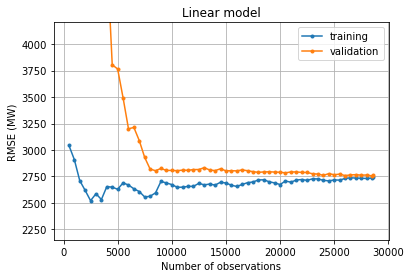

In [82]:
plot_learning_curves(steps, train_mse, val_mse, title="Linear model")

It is interesting to note that linear model performance significantly improves once we feed it the first year data (up to ±8760 hours), but does not further improve significantly as we feed it the next years' data.

Let's now see what performance we achieve with the random forest. Validation error drops to ±2360MW while training error lies around 1730MW, which would indicate that the model overfits the training data.

In [83]:
random_forest_regressor_model, rf_steps, rf_train_mse, rf_val_mse = compute_learning_curves(
    rf_model, "RandomForestRegressor", X_train_prep, y_train, 500, verbose=True
)

Iteration 1/58: train_rmse=534.95, val_rmse=2661.71
Iteration 2/58: train_rmse=424.17, val_rmse=2567.83
Iteration 3/58: train_rmse=472.18, val_rmse=2577.53
Iteration 4/58: train_rmse=449.40, val_rmse=2493.86
Iteration 5/58: train_rmse=657.54, val_rmse=2281.31
Iteration 6/58: train_rmse=676.47, val_rmse=2173.34
Iteration 7/58: train_rmse=827.90, val_rmse=2164.50
Iteration 8/58: train_rmse=812.98, val_rmse=2125.55
Iteration 9/58: train_rmse=930.42, val_rmse=2056.56
Iteration 10/58: train_rmse=921.58, val_rmse=1986.47
Iteration 11/58: train_rmse=1012.48, val_rmse=1866.40
Iteration 12/58: train_rmse=1013.94, val_rmse=1899.45
Iteration 13/58: train_rmse=1062.74, val_rmse=1901.81
Iteration 14/58: train_rmse=1035.50, val_rmse=1889.94
Iteration 15/58: train_rmse=1079.40, val_rmse=1882.05
Iteration 16/58: train_rmse=1064.94, val_rmse=1885.94
Iteration 17/58: train_rmse=1123.19, val_rmse=1941.28
Iteration 18/58: train_rmse=1168.89, val_rmse=1850.90
Iteration 19/58: train_rmse=1187.95, val_rmse=1

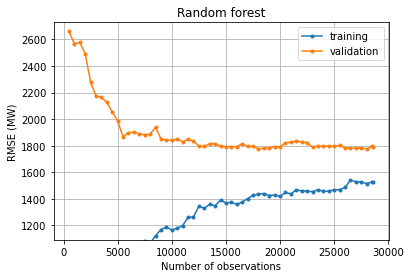

In [84]:
plot_learning_curves(rf_steps, rf_train_mse, rf_val_mse, title="Random forest")

XGBoost model pushes RMSE even further to 2050MW with training RMSE of only 260MW. This indicates once again that our model is overfitting the training data. We will try to handle the overfitting later on at model fine-tuning step.

In [85]:
xgb_regressor_model, xgb_steps, xgb_train_mse, xgb_val_mse = compute_learning_curves(
    xgb_model, "XGBRegressor", X_train_prep, y_train, 500, verbose=True
)

Iteration 1/58: train_rmse=0.01, val_rmse=2854.60
Iteration 2/58: train_rmse=0.01, val_rmse=2634.86
Iteration 3/58: train_rmse=0.01, val_rmse=2546.35
Iteration 4/58: train_rmse=0.01, val_rmse=2398.95
Iteration 5/58: train_rmse=0.03, val_rmse=2282.43
Iteration 6/58: train_rmse=0.09, val_rmse=2379.90
Iteration 7/58: train_rmse=0.20, val_rmse=2217.48
Iteration 8/58: train_rmse=0.43, val_rmse=2207.35
Iteration 9/58: train_rmse=0.67, val_rmse=2001.91
Iteration 10/58: train_rmse=1.34, val_rmse=1959.61
Iteration 11/58: train_rmse=1.95, val_rmse=1874.71
Iteration 12/58: train_rmse=2.74, val_rmse=1859.25
Iteration 13/58: train_rmse=3.62, val_rmse=1877.36
Iteration 14/58: train_rmse=4.97, val_rmse=1860.28
Iteration 15/58: train_rmse=5.85, val_rmse=1854.75
Iteration 16/58: train_rmse=8.29, val_rmse=1831.40
Iteration 17/58: train_rmse=10.54, val_rmse=1811.56
Iteration 18/58: train_rmse=13.81, val_rmse=1764.95
Iteration 19/58: train_rmse=16.80, val_rmse=1786.23
Iteration 20/58: train_rmse=18.84, va

KeyboardInterrupt: 

In [ ]:
import mlflow.xgboost

tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
if tracking_url_type_store != "file":
    # Register the model
    mlflow.xgboost.log_model(xgb_regressor_model, "XGB Regressor Model",
                             registered_model_name="XGB Regressor Model")
else:
    mlflow.xgboost.log_model(xgb_regressor_model, "XGB Regressor Model")

In [ ]:
plot_learning_curves(xgb_steps, xgb_train_mse, xgb_val_mse, title="XGB")

In [ ]:
## Fine-tuning the model

## Fine-tuning the model

In this part, we will start from the XGB model that we previously trained, and try to optimize its hyperparameters. To do so, we'll use a straightforward grid search approach (grid searh CV).

### Grid search cross validation

The following function applies grid search CV with XGB models. In particular, it uses the parameter `early_stopping_rounds` to interrupt training when validation error stops improving for $n$ iterations where $n$ is the parameter's value.

Early stopping is a way to prevent overfitting and reduce computation time. We will also try to reduce overfitting by optimizing XGB hyperparameters `eta` (learning rate) and `max_depth`.

In [ ]:
def xgb_grid_search_cv(
    params_grid, X, y, nfold,
    num_boost_round=1000, early_stopping_rounds=10,
):
    params_grid = ParameterGrid(params_grid)
    search_results = []
    print(f"Grid search CV : nfold={nfold}, " +
          f"numb_boost_round={num_boost_round}, " +
          f"early_stopping_round={early_stopping_rounds}")
    for params in params_grid:
        print(f"\t{params}")
        cv_df = xgb_cv(
            params=params, dtrain=DMatrix(X, y), nfold=nfold,
            num_boost_round=num_boost_round,
            early_stopping_rounds=early_stopping_rounds,
            shuffle=False, metrics={"rmse"},
        )
        cv_results = params.copy()
        cv_results["train-rmse-mean"] = cv_df["train-rmse-mean"].min()
        cv_results["test-rmse-mean"] = cv_df["test-rmse-mean"].min()
        search_results.append(cv_results)
    return pd.DataFrame(search_results)
    

The following code runs a 4-fold cross-validation on a hyperparameter grid of 18 possible combinations. So it will train a total of 72 models.

In [ ]:
params_grid = dict(
    eta = [0.05, 0.1, 0.3],
    max_depth = [2, 4, 6],
    min_child_weight = [5, 1]
)
xgb_search_scores = xgb_grid_search_cv(
    params_grid, X_train_prep, y_train, nfold=4, early_stopping_rounds=10
)

Results of the grid search are the following :

In [ ]:
xgb_search_scores.sort_values(by="test-rmse-mean")

### Training our final model

Based on previous result, we can train our final model on the whole training set

In [ ]:
final_model = XGBRegressor(
    n_estimators=1000, learning_rate=0.05, max_depth=6, min_child_weight=5
)
final_model.fit(
    X_train_prep, y_train, early_stopping_rounds=10,
    eval_set=[(X_train_prep, y_train), (X_test_prep, y_test)],
    verbose=False,
)

## Predictions on test set

Our final XGB model achieves RMSE score of ±1740MW on test set

In [ ]:
final_model.best_score

Let's group predicted and actual test data into a data frame

In [ ]:
def compute_predictions_df(model, X, y):
    y_pred = model.predict(X)
    df = pd.DataFrame(dict(actual=y, prediction=y_pred), index=X.index)
    df["squared_error"] =  (df["actual"] - df["prediction"])**2
    return df

pred_df = compute_predictions_df(
    final_model, X_test_prep, y_test
)
pred_df.head()

Comparing actual and predicted curves on the test set :

In [ ]:
def plot_predictions(pred_df, start=None, end=None):
    _, ax = plt.subplots(1, 1, figsize=(12, 5))
    start = start or pred_df.index.min()
    end = end or pred_df.index.max()
    pred_df.loc[
        (pred_df.index >= start) & (pred_df.index <= end),
        ["actual", "prediction"]
    ].plot.line(ax=ax)
    ax.set_title("Predictions on test set")
    ax.set_ylabel("MW")
    ax.grid()

plot_predictions(pred_df)

### Special time intervals

The intervals 
* 15th Apr. 2019 – 6th May 2019, and
* 16th Dec. 2019 – 6th Jan 2020

seem slightly irregular compared to the rest. This is most likely due to holiday periods. Let's zoom on these periods  to check how our predictions perform. 

In [ ]:
plot_predictions(pred_df,
                 start=pd.Timestamp("2019-04-15", tz="utc"),
                 end=pd.Timestamp("2019-05-06", tz="utc"))

Performance drops slightly around 21st of April and on May 2nd. For the 2nd of May, this could be explained by the fact that 1st of May is a national holiday in Germany, and that the model is using lag features to estimate May 2nd volume using May 1st without properly adapting scale (as May 2nd is not a holiday).

Appart from these, our model does a reasonable job at predicting volumes.

In [ ]:
plot_predictions(pred_df,
                 start=pd.Timestamp("2019-12-16", tz="utc"),
                 end=pd.Timestamp("2020-01-06", tz="utc"))

Here we observe that our model is slightly overestimating consumption during Christmas period and New Year's Eve.

### Best and worst prediction days

The days with worst prediction performance are the following :

In [ ]:
daily_pred_df = pred_df.groupby(pd.Grouper(freq="D")).mean()
daily_pred_df.sort_values(by="squared_error", ascending=False).head(5)

We find back the Labour Day's and end of year's periods in the above list. We also observe poor performance on the 20th of June :

In [ ]:
plot_predictions(pred_df,
                 start=pd.Timestamp("2019-06-19", tz="utc"),
                 end=pd.Timestamp("2019-06-22", tz="utc"))

Our model is largely overestimating consumption on 20th of June. This date is actually a *regional* holiday in Germany (Fronleichnam) which are currently not taken into account by our model. These only and happen in specific states, but still have an impact on the load at country level.

Looking at the best predictions, we have the following days :

In [ ]:
daily_pred_df.sort_values(by="squared_error", ascending=True).head(5)

Predictions were particularly accurate on 23rd and 25th of January 2020, as we can see from the graph below.

In [ ]:
plot_predictions(pred_df,
                 start=pd.Timestamp("2020-01-23", tz="utc"),
                 end=pd.Timestamp("2020-01-26", tz="utc"))

## Conclusion and next steps

Gradient boosting model achieves reasonable performance (RMSE of ±1740MW) at load forecasting at country level. The most relevant features for this task are lag features, especially at H-24 and H-48. Week-ends and holidays have less impact, but are still relevant to use.

To further improve the model, additional features could be taken into account such as
* additional lag features (beyond H-48),
* regional holidays,
* temperature data.